<center><h1><b>Exploratory Data Analysis</b></h1></center>
<center><h3><b>Candidate 26527, Candidate 24738, Candidate 25411 , Candidate 34553</b></h3></center>

##### Table of Contents
- [Bus and Tube Exploratory Data Analysis](#heading-1)
  - [Importing the bus data from HDFS,](#subheading-11)
  - [Importing the tube data from HDFS](#subheading-12)
  - [Importing the shapefile data for london base map from HDFS](#subheading-13)
  - [Importing the data for cycle hires and cycle stands from BigQuery](#subheading-14)
  - [Visualizations of cycle stands , buses , and tube stations on london base map](#subheading-15)
- [Popularity of bus and tube stations by cycle hires](#heading-2)
  - [Establishing BigQuery GIS connection and reading the datasets into a database](#subheading-22)
  - [Performing a Geo-spatial Join and buffer as 100 meters](#subheading-23) 
-[Finding nearest distance to bus stops](#heading-3)
- [Chisquare test](#heading-4)

## Importing Libraries

In [1]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, unix_timestamp, floor, sum, to_date, round, max, hour, avg, concat, lit, dayofweek, date_format
import pandas as pd
import numpy as np
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import year
! pip install pyspark_dist_explore
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pyspark.sql import Window
from statsmodels.graphics.tsaplots import plot_acf
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, size, array, collect_list, array_repeat, concat_ws, Column
import warnings
import requests
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.linalg import Vectors
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql.functions import from_unixtime, to_timestamp

## Bus and Tube Exploratory Data Analysis

### Importing the bus data from HDFS

In [47]:
#Importing bus stops data for london from hdfs
bus_df = spark.read.csv('hdfs:///user/r_g_sanap/newdir/bus_stops_london.csv', header=True, inferSchema=True) # put ur own hdfs path
#The values look flipped undoing it , as the latitude and longitudes were flipped in the original data
bus_df = bus_df.withColumnRenamed('Latitude', 'temp') \
               .withColumnRenamed('Longitude', 'Latitude') \
               .withColumnRenamed('temp', 'Longitude')

# Show the result to confirm changes
bus_df.show()

+--------------+-------------+-----------+--------------------+----------------+-----------------+-------+---------+----------------+--------------------+------------------+
|Stop_Code_LBSL|Bus_Stop_Code|Naptan_Atco|           Stop_Name|Location_Easting|Location_Northing|Heading|Stop_Area|Virtual_Bus_Stop|           Longitude|          Latitude|
+--------------+-------------+-----------+--------------------+----------------+-----------------+-------+---------+----------------+--------------------+------------------+
|          1000|        91532| 490000266G|WESTMINSTER STATI...|        530171.0|         179738.0|  177.0|     0K08|             0.0| -0.1259881863671396| 51.50159700396406|
|         10001|        72689| 490013793E|        TREVOR CLOSE|        515781.0|         174783.0|   78.0|     NB16|             0.0| -0.3348309198683003| 51.46019101494074|
|         10002|        48461| 490000108F|     HIGHBURY CORNER|        531614.0|         184603.0|    5.0|     C902|             0

In [71]:
#There are some missing values, cleaning them for the spatial join later.
cleaned_bus_df = bus_df.dropna()
# Check the count of missing values again
missing_values_after_drop = {col_name: cleaned_bus_df.filter(col(col_name).isNull()).count() for col_name in cleaned_bus_df.columns}
# Print the count of missing values for each column after dropping rows
for col_name, count in missing_values_after_drop.items():
    print(f"Column '{col_name}' has {count} missing value(s) after dropping.")

Column 'Stop_Code_LBSL' has 0 missing value(s) after dropping.
Column 'Bus_Stop_Code' has 0 missing value(s) after dropping.
Column 'Naptan_Atco' has 0 missing value(s) after dropping.
Column 'Stop_Name' has 0 missing value(s) after dropping.
Column 'Location_Easting' has 0 missing value(s) after dropping.
Column 'Location_Northing' has 0 missing value(s) after dropping.
Column 'Heading' has 0 missing value(s) after dropping.
Column 'Stop_Area' has 0 missing value(s) after dropping.
Column 'Virtual_Bus_Stop' has 0 missing value(s) after dropping.
Column 'Longitude' has 0 missing value(s) after dropping.
Column 'Latitude' has 0 missing value(s) after dropping.


In [51]:
#Schema of bus 
bus_df.printSchema()

root
 |-- Stop_Code_LBSL: string (nullable = true)
 |-- Bus_Stop_Code: string (nullable = true)
 |-- Naptan_Atco: string (nullable = true)
 |-- Stop_Name: string (nullable = true)
 |-- Location_Easting: double (nullable = true)
 |-- Location_Northing: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- Stop_Area: string (nullable = true)
 |-- Virtual_Bus_Stop: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)



### Importing the tube data from HDFS

In [2]:
#Importing the london tube stations
tube_df = spark.read.csv('hdfs:///user/r_g_sanap/newdir/london-stations.csv', header=True, inferSchema=True) # put ur own hdfs path
tube_df.show()

+---+--------+---------+------------+-----------------+----+-----------+----+
| id|latitude|longitude|        name|     display_name|zone|total_lines|rail|
+---+--------+---------+------------+-----------------+----+-----------+----+
|  1| 51.5028|  -0.2801|  Acton Town|  Acton<br />Town|   3|          2|   0|
|  2| 51.5143|  -0.0755|     Aldgate|             NULL|   1|          2|   0|
|  3| 51.5154|  -0.0726|Aldgate East|Aldgate<br />East|   1|          2|   0|
|  4| 51.5107|   -0.013|  All Saints|  All<br />Saints|   2|          1|   0|
|  5| 51.5407|  -0.2997|    Alperton|             NULL|   4|          1|   0|
|  7| 51.5322|  -0.1058|       Angel|             NULL|   1|          1|   0|
|  8| 51.5653|  -0.1353|     Archway|             NULL|   2|          1|   0|
|  9| 51.6164|  -0.1331| Arnos Grove| Arnos<br />Grove|   4|          1|   0|
| 10| 51.5586|  -0.1059|     Arsenal|             NULL|   2|          1|   0|
| 11| 51.5226|  -0.1571|Baker Street|Baker<br />Street|   1|    

Importing the shapefile data for london base map from HDFS

In [3]:
#Importing the shapefile for london
file_path = 'hdfs:///user/r_g_sanap/newdir/london.csv'  # Or use the VM's filesystem path
map = spark.read.csv(file_path, header=True, inferSchema=True)

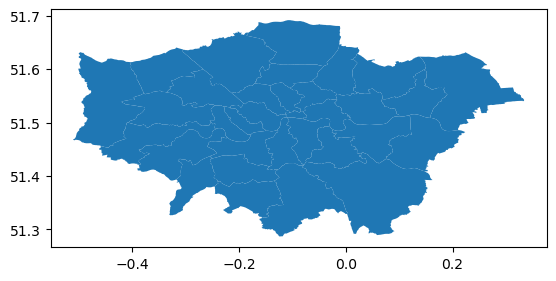

In [100]:
#Testin the london base map 
pdf = map.limit(1000).toPandas()
# Convert WKT geometry strings to Shapely geometries
pdf['geometry'] = pdf['geometry'].apply(wkt.loads)
# Convert to a GeoPandas DataFrame
gdf = gpd.GeoDataFrame(pdf, geometry='geometry')
# Plot using GeoPandas
gdf.plot()
plt.show()


Importing the data for cycle hires and cycle stands from BigQuery 

In [5]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BigQuery Read") \
    .getOrCreate()

# Dataset name
dataset_name = "london_bicycles"

# Table names
cycle_hire_table_name = "cycle_hire"
cycle_stations_table_name = "cycle_stations"

# Full table IDs including project, dataset, and table names
cycle_hire_table_id = f"bigquery-public-data.{dataset_name}.{cycle_hire_table_name}"
cycle_stations_table_id = f"bigquery-public-data.{dataset_name}.{cycle_stations_table_name}"

# Read data from the cycle_hire table in BigQuery
cycle_hire_df = spark.read \
    .format("bigquery") \
    .option("table", cycle_hire_table_id) \
    .load()

# Read data from the cycle_stations table in BigQuery
cycle_stations_df = spark.read \
    .format("bigquery") \
    .option("table", cycle_stations_table_id) \
    .load()

24/04/06 11:48:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
# Show the data to confirm it's been read properly
cycle_hire_df.take(1)

[Row(rental_id=57870195, duration=3840, duration_ms=3840000, bike_id=4229, bike_model='', end_date=datetime.datetime(2016, 8, 31, 20, 49), end_station_id=None, end_station_name='Golden Square, Soho', start_date=datetime.datetime(2016, 8, 31, 19, 45), start_station_id=None, start_station_name='Albert Gate, Hyde Park', end_station_logical_terminal=3451, start_station_logical_terminal=1132, end_station_priority_id=0)]

In [7]:
cycle_stations_df.show(2)

+---+---------+-----------+------+------------+--------------------+-----------+-----------+------------+---------+-------------+------------+------------+
| id|installed|   latitude|locked|   longitude|                name|bikes_count|docks_count|nbEmptyDocks|temporary|terminal_name|install_date|removal_date|
+---+---------+-----------+------+------------+--------------------+-----------+-----------+------------+---------+-------------+------------+------------+
| 66|     true|51.51795029| false|-0.108657431|Holborn Circus, H...|          0|         40|          37|    false|          982|  2010-07-11|        null|
|126|     true|51.51782144| false|-0.096496865|Museum of London,...|          0|         52|          52|    false|         1043|  2010-07-15|        null|
+---+---------+-----------+------+------------+--------------------+-----------+-----------+------------+---------+-------------+------------+------------+
only showing top 2 rows



In [12]:
#cycle hires filtered by year and count the rows
hires = cycle_hire_df.filter((year(cycle_hire_df["start_date"]).isin([2019, 2020])) & (year(cycle_hire_df["end_date"]).isin([2019, 2020])))
initial_hires_count = hires.count()
initial_hires_count

20596695

In [13]:
#Joining the cycle hires with  stations on stand ids
# Ensure the station IDs are integers in both DataFrames if they are not already
cycle_stations_df = cycle_stations_df.withColumn("id", col("id").cast("integer"))

hires = hires.withColumn("start_station_id", col("start_station_id").cast("integer")) \
             .withColumn("end_station_id", col("end_station_id").cast("integer"))

# Join the hires DataFrame with the start and end station details from cycle_stations_df
# Start Station Join
hires_with_start_stations = hires.join(
    cycle_stations_df,
    hires.start_station_id == cycle_stations_df.id,
    how='left'
).select(hires["*"], 
         col("latitude").alias("start_station_latitude"), 
         col("longitude").alias("start_station_longitude"))

# End Station Join
hires_with_stations = hires_with_start_stations.join(
    cycle_stations_df,
    hires_with_start_stations.end_station_id == cycle_stations_df.id,
    how='left'
).select(
    hires_with_start_stations["*"], 
    col("latitude").alias("end_station_latitude"), 
    col("longitude").alias("end_station_longitude")
)


In [14]:
#Checking for missing values before and after joining
hires_with_stations_count = hires_with_stations.count()
print("Initial hires count: ", initial_hires_count)
print("Count after join: ", hires_with_stations_count)


Initial hires count:  20596695
Count after join:  20596695


In [15]:
#Drop the rows with missing values 
hire_with_stations = hires_with_stations.dropna(subset=["start_station_latitude", "start_station_longitude", 
                                                  "end_station_latitude", "end_station_longitude"])

Visualizations of cycle stands , buses , and tube stations on london base map

In [16]:
#Converting all the three dfs to pandas and then to GeoDataframes 
#Cycles stands
cycle_stations_pd = cycle_stations_df.toPandas()
#now creating a geodf

# Create a GeoDataFrame for cycle stations
cycle_stations_gpd = gpd.GeoDataFrame(
    cycle_stations_pd, 
    geometry=gpd.points_from_xy(cycle_stations_pd.longitude, cycle_stations_pd.latitude)
)
cycle_stations_gpd.set_crs(epsg=4326, inplace=True)
#Bus stops
bus_stops_pdf = bus_df.toPandas()
# Ensure that the latitude and longitude columns are of type float
bus_stops_pdf['Latitude'] = pd.to_numeric(bus_stops_pdf['Latitude'], errors='coerce')
bus_stops_pdf['Longitude'] = pd.to_numeric(bus_stops_pdf['Longitude'], errors='coerce')
# Drop any rows that couldn't be converted to floats (e.g., if there were any non-numeric values)
bus_stops_pdf = bus_stops_pdf.dropna(subset=['Latitude', 'Longitude'])
# Create a GeoDataFrame from the latitude and longitude columns
bus_stops_gdf = gpd.GeoDataFrame(
    bus_stops_pdf,
    geometry=gpd.points_from_xy(bus_stops_pdf['Longitude'], bus_stops_pdf['Latitude']),
    crs="EPSG:4326"  # Set the coordinate reference system
)
#Tube stations
#Convert tubedf to pandas df then to geodf 
tube_pd = tube_df.toPandas()
# Create a GeoDataFrame
gdf_tube = gpd.GeoDataFrame(
    tube_pd,
    geometry=[Point(xy) for xy in zip(tube_pd.longitude, tube_pd.latitude)],
    crs="epsg:4326"
)

Cycle stands 

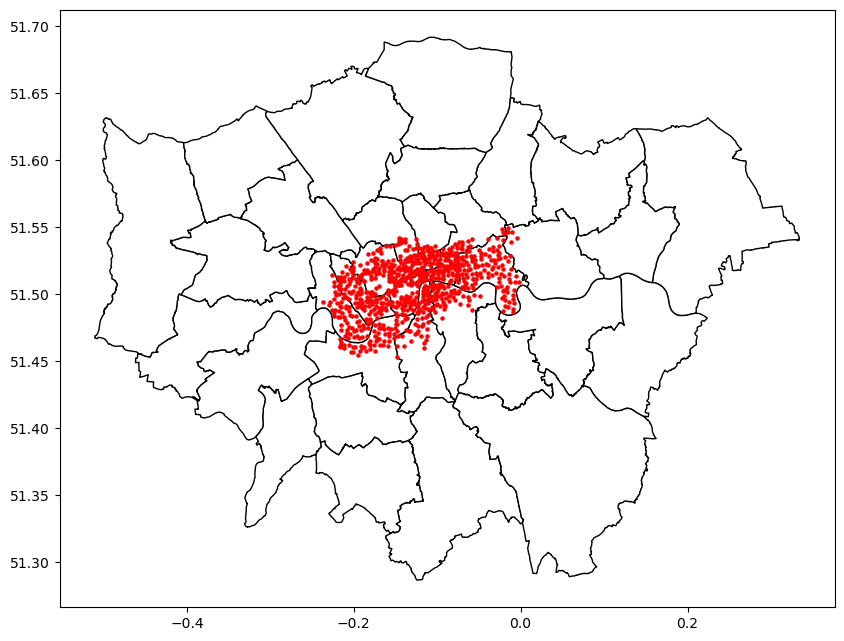

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot London boroughs
gdf.plot(ax=ax, color='white', edgecolor='black')  # Note the use of the GeoDataFrame object 'gdf'
# Plot cycle stations
cycle_stations_gpd.plot(ax=ax, markersize=5, color='red')  # And 'cycle_stations_gpd' for the cycle stations
plt.show()

Cycle stands with Bus stops

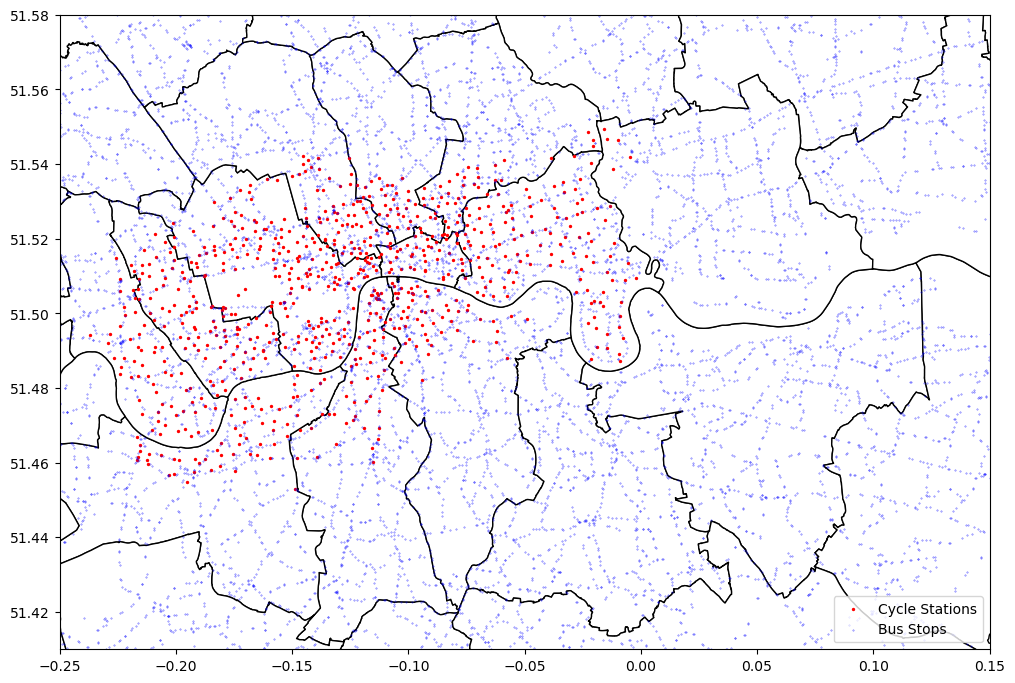

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the boroughs
gdf.plot(ax=ax, color='white', edgecolor='black')

# Plot the cycle stations
cycle_stations_gpd.plot(ax=ax, color='red', markersize=2, label='Cycle Stations')

# Plot the bus stops
bus_stops_gdf.plot(ax=ax, color='blue', markersize=0.1, label='Bus Stops', alpha=0.7)

# Adjust the x and y axis limits if needed
ax.set_xlim([-0.25, 0.15])  # replace with the min and max longitude values
ax.set_ylim([51.41, 51.58])  # replace with the min and max latitude values

# Add a legend to the plot
ax.legend()

plt.show()


Cycle stands, bus stops and Tube stations 

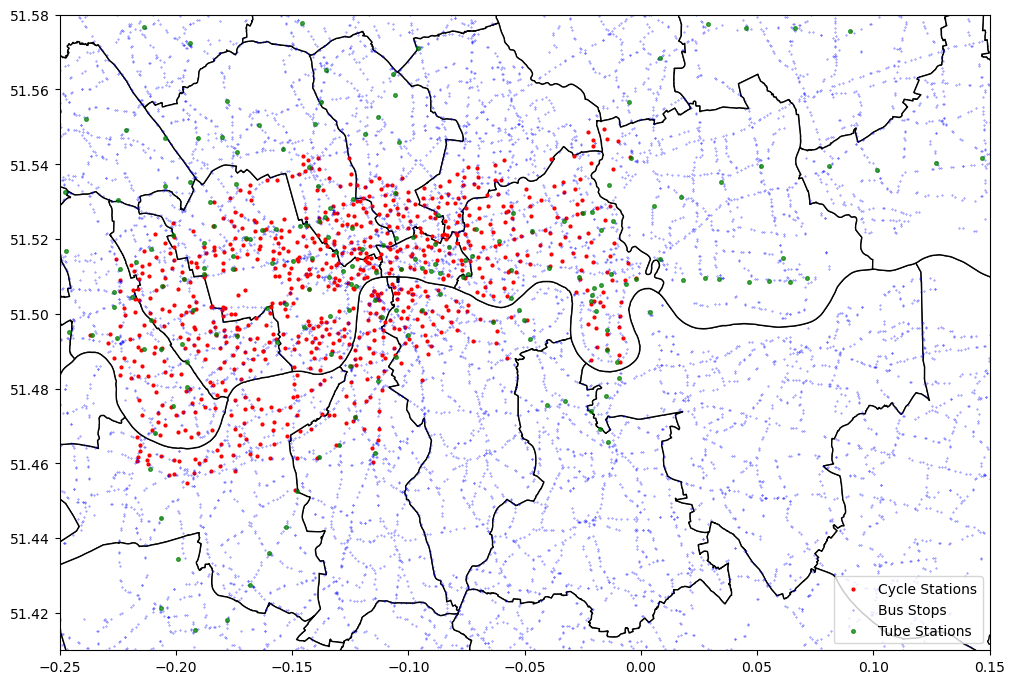

In [20]:
#Plot with the cycle stands 
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the boroughs
gdf.plot(ax=ax, color='white', edgecolor='black')

# Plot the cycle stations
cycle_stations_gpd.plot(ax=ax, color='red', markersize=4, label='Cycle Stations')

# Plot the bus stops
bus_stops_gdf.plot(ax=ax, color='blue', markersize=0.1, label='Bus Stops', alpha=0.7)

#Tube
gdf_tube.plot(ax=ax, color='green', markersize=7, label='Tube Stations', alpha=0.7)


# Adjust the x and y axis limits if needed
ax.set_xlim([-0.25, 0.15])  # replace with the min and max longitude values
ax.set_ylim([51.41, 51.58])  # replace with the min and max latitude values

# Add a legend to the plot
ax.legend()
plt.show()


Popularity of bus and tube stations by cycle hires

Establishing BigQuery GIS connection and reading the datasets into a database

In [52]:
# Initialize Spark Session
spark = SparkSession \
    .builder \
    .appName("BigQuery GIS with PySpark") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.22.0") \
    .getOrCreate()

# Use the Cloud Storage bucket for temporary BigQuery export data used by the connector.
bucket = "bucket-for-gis"
spark.conf.set('temporaryGcsBucket', bucket)



In [72]:
# Read the tables into DataFrames
#For bus data 
# Define table name and dataset in BigQuery
dataset_name = 'transfer-pattern:bus_stops_london'
table_name = 'bus_stops'
# Full table reference
table_ref = f"{dataset_name}.{table_name}"
# Extract the schema of the DataFrame
schema = cleaned_bus_df.schema
# Write the dataframe to BigQuery with the specified schema
(cleaned_bus_df
 .write
 .format("bigquery")
 .option("table", table_ref)
 .option("schema", ",".join([f"{field.name}:{field.dataType}" for field in schema]))
 .mode("overwrite")
 .save())

In [41]:
# Read the tables into DataFrames
#For bus data 
# Define table name and dataset in BigQuery
dataset_name = 'transfer-pattern:bus_stops_london'
table_name = 'cycle_hire'
# Full table reference
table_ref = f"{dataset_name}.{table_name}"
# Write the dataframe to BigQuery
hire_with_stations.write \
  .format("bigquery") \
  .option("table", table_ref) \
  .mode("overwrite") \
  .save()

In [125]:
#Read the tube data as well 
dataset_name = 'transfer-pattern:bus_stops_london'
table_name = 'tube_stations'
# Full table reference
table_ref = f"{dataset_name}.{table_name}"
# Write the dataframe to BigQuery
tube_df.write \
  .format("bigquery") \
  .option("table", table_ref) \
  .mode("overwrite") \
  .save()


Now, 3 of the dataframes are read into dataset 

In [54]:
#Reading from the dfs o confirm table formation
# Read the first few rows of the cycle_hire table
#Table name - cycle_hire 
cycle_hire_df = spark.read \
    .format("bigquery") \
    .option("table", "transfer-pattern:bus_stops_london.cycle_hire") \
    .load()

cycle_hire_df.show(n=3)


+---------+--------+-----------+-------+----------+-------------------+--------------+----------------+-------------------+----------------+------------------+----------------------------+------------------------------+-----------------------+----------------------+-----------------------+--------------------+---------------------+
|rental_id|duration|duration_ms|bike_id|bike_model|           end_date|end_station_id|end_station_name|         start_date|start_station_id|start_station_name|end_station_logical_terminal|start_station_logical_terminal|end_station_priority_id|start_station_latitude|start_station_longitude|end_station_latitude|end_station_longitude|
+---------+--------+-----------+-------+----------+-------------------+--------------+----------------+-------------------+----------------+------------------+----------------------------+------------------------------+-----------------------+----------------------+-----------------------+--------------------+---------------------

In [73]:
bus_stops_df = spark.read \
    .format("bigquery") \
    .option("table", "transfer-pattern:bus_stops_london.bus_stops") \
    .load()

bus_stops_df.show(n=10)

+--------------+-------------+-----------+--------------------+----------------+-----------------+-------+---------+----------------+--------------------+------------------+
|Stop_Code_LBSL|Bus_Stop_Code|Naptan_Atco|           Stop_Name|Location_Easting|Location_Northing|Heading|Stop_Area|Virtual_Bus_Stop|           Longitude|          Latitude|
+--------------+-------------+-----------+--------------------+----------------+-----------------+-------+---------+----------------+--------------------+------------------+
|         11760|        56520|490000240JJ|TURNHAM GREEN STA...|        521208.0|         178744.0|    0.0|     Q609|             0.0| -0.2553945893218932|51.494654930658875|
|         17501|        71270| 490006542N|KINGSGROUND / ELT...|        542340.0|         174436.0|    0.0|     G907|             0.0| 0.04708383819958998| 51.45102381163308|
|         18939|        51147| 490001318B|   WELLING STATION #|        545975.0|         176006.0|    0.0|     E902|             0

In [62]:
tube_stations_df = spark.read \
    .format("bigquery") \
    .option("table", "transfer-pattern:bus_stops_london.tube_stations") \
    .load()

tube_stations_df.show(n=10)

+---+--------+---------+----------------+--------------------+----+-----------+----+
| id|latitude|longitude|            name|        display_name|zone|total_lines|rail|
+---+--------+---------+----------------+--------------------+----+-----------+----+
|  7| 51.5322|  -0.1058|           Angel|                NULL|   1|          1|   0|
| 29| 51.5011|  -0.0943|         Borough|                NULL|   1|          1|   0|
| 48| 51.5185|  -0.1111|   Chancery Lane|  Chancery<br />Lane|   1|          1|   0|
| 60| 51.5129|  -0.1243|   Covent Garden|  Covent<br />Garden|   1|          1|   0|
| 82| 51.5199|  -0.1679|Edgware Road (B)|   Edgware<br />Road|   1|          1|   0|
|102| 51.5205|  -0.1347|   Goodge Street|  Goodge<br />Street|   1|          1|   0|
|133| 51.5027|  -0.1527|Hyde Park Corner|Hyde<br />Park<br...|   1|          1|   0|
|146| 51.5015|  -0.1607|   Knightsbridge|                NULL|   1|          1|   0|
|148| 51.4991|  -0.1115|   Lambeth North|  Lambeth<br />North|   

Performing a Geo-spatial Join and buffer as 100 meters

Geo- spatial join between bus stops and cycle hires. Due to computational constarints this join consists of cycle hires for January 2019

In [145]:
#Check for first half of 2019
spark = SparkSession.builder \
    .appName("BigQuery with Spark") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.22.0') \
    .getOrCreate()

nearest_bus_stops_query = '''
WITH NearestBusStops AS (
  SELECT 
    c.rental_id AS cycle_rental_id,
    c.duration AS cycle_duration,
    c.duration_ms AS cycle_duration_ms,
    c.start_station_id AS cycle_start_station_id,
    c.start_station_name AS cycle_start_station_name,
    c.start_station_latitude AS cycle_start_station_latitude,
    c.start_station_longitude AS cycle_start_station_longitude,
    b.Bus_Stop_Code AS bus_stop_code,
    b.Stop_Name AS stop_name,
    b.Naptan_Atco AS naptan_atco,
    b.Longitude AS longitude,
    b.Latitude AS latitude
  FROM 
    `transfer-pattern.bus_stops_london.cycle_hire` AS c
  CROSS JOIN 
    `transfer-pattern.bus_stops_london.bus_stops` AS b
  WHERE 
    c.start_date BETWEEN '2019-01-01' AND '2019-06-30'
)
SELECT 
  cycle_rental_id,
  cycle_duration,
  cycle_duration_ms,
  cycle_start_station_id,
  cycle_start_station_name,
  cycle_start_station_latitude,
  cycle_start_station_longitude,
  bus_stop_code,
  naptan_atco,
  stop_name,
  longitude,
  latitude,
  ST_DISTANCE(ST_GEOGPOINT(cycle_start_station_longitude, cycle_start_station_latitude), ST_GEOGPOINT(longitude, latitude)) AS distance
FROM 
  NearestBusStops
WHERE 
  ST_DISTANCE(ST_GEOGPOINT(cycle_start_station_longitude, cycle_start_station_latitude), ST_GEOGPOINT(longitude, latitude)) <= 100


'''
#viewsEnabled incurs extra costs 

nearest_bus_stops_df_dec = spark.read.format("bigquery") \
    .option("viewsEnabled", "true") \
    .option("materializationDataset", "bus_stops_london") \
    .option("query", nearest_bus_stops_query) \
    .load()



In [147]:
#Listing the most popular bus stops by cycle hires 
# Aggregate data by bus stop code and count the number of hires
bus_stop_counts_fh = nearest_bus_stops_df_dec.groupBy('bus_stop_code', 'stop_name', 'latitude', 'longitude').agg(
    F.count('cycle_rental_id').alias('number_of_hires')
).orderBy(F.desc('number_of_hires'))
# Show the top bus stop with the most hires
bus_stop_counts_fh.show(20)

+-------------+--------------------+------------------+--------------------+---------------+
|bus_stop_code|           stop_name|          latitude|           longitude|number_of_hires|
+-------------+--------------------+------------------+--------------------+---------------+
|        77305|WATERLOO STATION ...| 51.50426009931526|-0.11316998224296215|          94066|
|        59337|WATERLOO STATION ...| 51.50417319614032|-0.11279893222986268|          94066|
|        72073|WATERLOO STATION ...|  51.5043592304674| -0.1137422585516179|          94066|
|        75552|WATERLOO STATION ...| 51.50372780612174|-0.11306228801819879|          87828|
|        49952|WATERLOO STATION ...| 51.50392481579017|-0.11301092220011023|          87828|
|        73340|WATERLOO STATION ...| 51.50381586659135|-0.11350533266767521|          87828|
|        55382|WATERLOO STATION ...| 51.50359661307948| -0.1121743469527456|          56503|
|        47677|WATERLOO STATION ...| 51.50469733476796|-0.114636087559

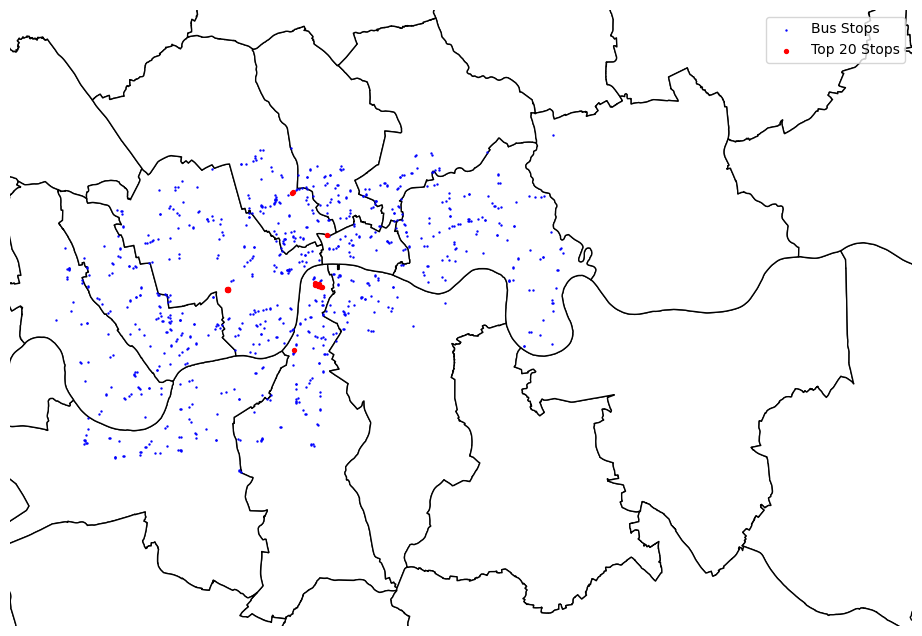

In [113]:
bus_stop_counts_pd = nearest_bus_stops_df_dec.toPandas()
# Sort the DataFrame by the number of hires in descending order
bus_stop_counts_pd.sort_values(by='number_of_hires', ascending=False, inplace=True)
# Add a new column to highlight the top 20 bus stops
bus_stop_counts_pd['is_top_20'] = bus_stop_counts_pd.index < 20

# Convert the DataFrame to a GeoDataFrame
feb_gdf = gpd.GeoDataFrame(
    bus_stop_counts_pd, 
    geometry=gpd.points_from_xy(bus_stop_counts_pd.longitude, bus_stop_counts_pd.latitude)
)
# Set the coordinate reference system (CRS) to WGS84 (epsg:4326)
feb_gdf.crs = 'EPSG:4326'
#PLot 
# Create a base map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(ax=ax, color='white', edgecolor='black')
# Set the limits to zoom into the central area of London
ax.set_xlim([-0.25, 0.15])  # Min and max longitude
ax.set_ylim([51.41, 51.58])  # Min and max latitude
# Plot all bus stops
feb_gdf.plot(ax=ax, color='blue', markersize=0.5, label='Bus Stops')

# Highlight the top 20 bus stops
feb_gdf[feb_gdf['is_top_20']].plot(ax=ax, color='red', markersize=8, label='Top 20 Stops')

# Add a legend to the plot
ax.legend()

# Remove axis for a cleaner look
ax.axis('off')

# Show the plot
plt.show()




Waterloo, Holborn, Hyde park appear to be popular hires.


Geo-spatial join between tube stations and cycle hires. Due to computational constarints this join consists of cycle hires for January 2019

In [133]:
#For the first half of 2019
spark = SparkSession.builder \
    .appName("BigQuery with Spark") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.22.0') \
    .getOrCreate()

nearest_tube_stops_query = '''
WITH NearestTubeStations AS (
  SELECT 
    c.rental_id AS cycle_rental_id,
    c.duration AS cycle_duration,
    c.duration_ms AS cycle_duration_ms,
    c.start_station_id AS cycle_start_station_id,
    c.start_station_name AS cycle_start_station_name,
    c.start_station_latitude AS cycle_start_station_latitude,
    c.start_station_longitude AS cycle_start_station_longitude,
    t.id AS tube_station_id,
    t.name AS tube_station_name,
    t.latitude AS latitude,
    t.longitude AS longitude
  FROM 
    `transfer-pattern.bus_stops_london.cycle_hire` AS c
  CROSS JOIN 
    `transfer-pattern.bus_stops_london.tube_stations` AS t
  WHERE 
    c.start_date BETWEEN '2019-01-01' AND '2019-06-30'
)
SELECT 
  cycle_rental_id,
  cycle_duration,
  cycle_duration_ms,
  cycle_start_station_id,
  cycle_start_station_name,
  cycle_start_station_latitude,
  cycle_start_station_longitude,
  tube_station_id,
  tube_station_name,
  latitude,
  longitude,
  ST_DISTANCE(ST_GEOGPOINT(cycle_start_station_longitude, cycle_start_station_latitude), ST_GEOGPOINT(longitude, latitude)) AS distance
FROM 
  NearestTubeStations
WHERE 
  ST_DISTANCE(ST_GEOGPOINT(cycle_start_station_longitude, cycle_start_station_latitude), ST_GEOGPOINT(longitude, latitude)) <= 100


'''
#viewsEnabled incurs extra costs 

nearest_tube_stops_firsthalf = spark.read.format("bigquery") \
    .option("viewsEnabled", "true") \
    .option("materializationDataset", "bus_stops_london") \
    .option("query", nearest_tube_stops_query ) \
    .load()



In [135]:
#Top 20 tube stations by cycle hires 
tube_stop_counts = nearest_tube_stops_firsthalf.groupBy('tube_station_id', 'tube_station_name', 'latitude', 'longitude').agg(
    F.count('cycle_rental_id').alias('number_of_hires')
).orderBy(F.desc('number_of_hires'))
# Show the tube stations with the most hires
tube_stop_counts.show(20)

+---------------+--------------------+--------+---------+---------------+
|tube_station_id|   tube_station_name|latitude|longitude|number_of_hires|
+---------------+--------------------+--------+---------+---------------+
|            279|            Waterloo| 51.5036|  -0.1143|          49744|
|            133|    Hyde Park Corner| 51.5027|  -0.1527|          35577|
|            208|           Queensway| 51.5107|  -0.1877|          28154|
|            122|High Street Kensi...| 51.5009|  -0.1925|          21327|
|             49|       Charing Cross|  51.508|  -0.1247|          18095|
|            277|       Warren Street| 51.5247|  -0.1384|          16337|
|            236|    South Kensington| 51.4941|  -0.1738|          15264|
|            107|          Green Park| 51.5067|  -0.1428|          14258|
|            263|          Tower Hill| 51.5098|  -0.0766|          13696|
|            167|            Moorgate| 51.5186|  -0.0886|          13599|
|             96|     Fulham Broadway|

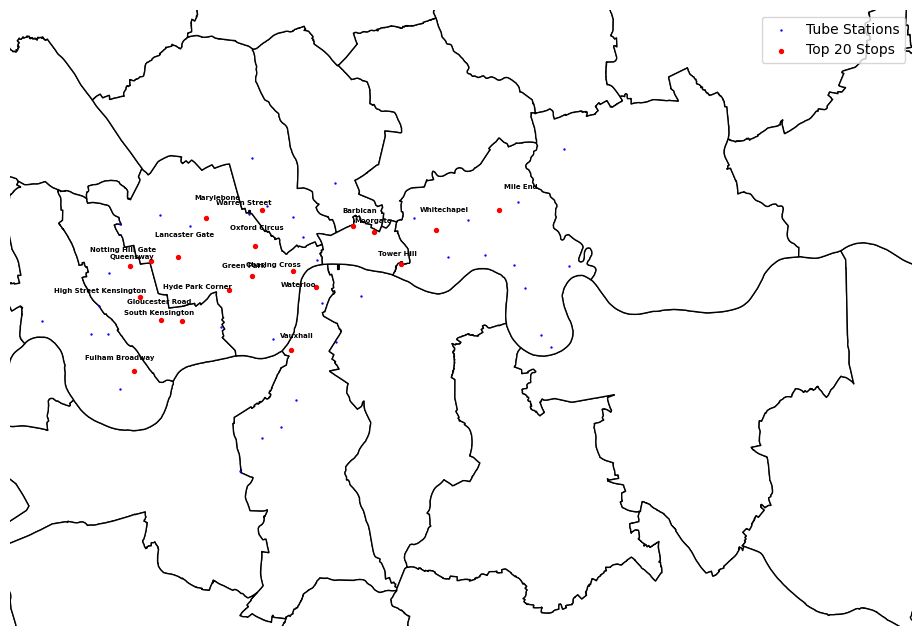

In [144]:
tube_stop_counts_pd = tube_stop_counts.toPandas()
# Sort the DataFrame by the number of hires in descending order
tube_stop_counts_pd.sort_values(by='number_of_hires', ascending=False, inplace=True)
# Add a new column to highlight the top 20 bus stops
tube_stop_counts_pd['is_top_20'] = tube_stop_counts_pd.index < 20

# Convert the DataFrame to a GeoDataFrame
firsthalf_gdf = gpd.GeoDataFrame(
    tube_stop_counts_pd, 
    geometry=gpd.points_from_xy(tube_stop_counts_pd.longitude, tube_stop_counts_pd.latitude)
)
# Set the coordinate reference system (CRS) to WGS84 (epsg:4326)
firsthalf_gdf.crs = 'EPSG:4326'
#PLot 
# Create a base map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(ax=ax, color='white', edgecolor='black')
# Set the limits to zoom into the central area of London
ax.set_xlim([-0.25, 0.15])  # Min and max longitude
ax.set_ylim([51.41, 51.58])  # Min and max latitude
# Plot all bus stops
firsthalf_gdf.plot(ax=ax, color='blue', markersize=0.5, label='Tube Stations')
firsthalf_gdf[firsthalf_gdf['is_top_20']].plot(ax=ax, color='red', markersize=8, label='Top 20 Stops')
x_offset, y_offset = 3, 3

for idx, row in firsthalf_gdf[firsthalf_gdf['is_top_20']].iterrows():
    # Calculate position for annotation to avoid overlaps.
    # Adjust the multiplier as needed to space out annotations properly.
    position = (row['longitude'] + x_offset * idx * 0.0003, row['latitude'] + y_offset * idx * 0.0001)
    ax.annotate(text=row['tube_station_name'], xy=(row['longitude'], row['latitude']),
                xytext=position, textcoords="data",
                fontsize=5, color='black', weight='bold', ha='right')
ax.legend()
# Remove axis for a cleaner look
ax.axis('off')

plt.show()

Finding nearest distance to bus stops

In [ ]:
#This is for one day '2019-01-01' AND '2019-01-02'  , computationally intensive
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BigQuery with Spark") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.22.0') \
    .getOrCreate()

new_var_query = '''
WITH NearestBusStops AS (
  SELECT
    c.rental_id AS rental_id_c,
    c.duration AS duration_c,
    c.duration_ms AS duration_ms_c,
    c.bike_id AS bike_id_c,
    c.bike_model AS bike_model_c,
    c.end_date AS end_date_c,
    c.end_station_id AS end_station_id_c,
    c.end_station_name AS end_station_name_c,
    c.start_date AS start_date_c,
    c.start_station_id AS start_station_id_c,
    c.start_station_name AS start_station_name_c,
    c.end_station_logical_terminal AS end_station_logical_terminal_c,
    c.start_station_logical_terminal AS start_station_logical_terminal_c,
    c.end_station_priority_id AS end_station_priority_id_c,
    c.start_station_latitude AS start_station_latitude_c,
    c.start_station_longitude AS start_station_longitude_c,
    b.Bus_Stop_Code AS Bus_Stop_Code_b,
    b.Stop_Name AS Stop_Name_b,
    ST_DISTANCE(ST_GEOGPOINT(c.start_station_longitude, c.start_station_latitude), 
                ST_GEOGPOINT(b.Longitude, b.Latitude)) AS distance
  FROM 
    `transfer-pattern.bus_stops_london.cycle_hire` AS c
  CROSS JOIN 
    `transfer-pattern.bus_stops_london.bus_stops` AS b
  WHERE 
    c.start_date BETWEEN '2019-01-01' AND '2019-01-02'  
)
SELECT 
  rental_id_c AS rental_id,
  duration_c AS duration,
  duration_ms_c AS duration_ms,
  bike_id_c AS bike_id,
  bike_model_c AS bike_model,
  end_date_c AS end_date,
  end_station_id_c AS end_station_id,
  end_station_name_c AS end_station_name,
  start_date_c AS start_date,
  start_station_id_c AS start_station_id,
  start_station_name_c AS start_station_name,
  end_station_logical_terminal_c AS end_station_logical_terminal,
  start_station_logical_terminal_c AS start_station_logical_terminal,
  end_station_priority_id_c AS end_station_priority_id,
  start_station_latitude_c AS start_station_latitude,
  start_station_longitude_c AS start_station_longitude,
  Bus_Stop_Code_b AS Bus_Stop_Code,
  Stop_Name_b AS Stop_Name,
  distance,
  MIN(distance) OVER (PARTITION BY rental_id_c) AS nearest_bus_stop_distance
FROM 
  NearestBusStops
ORDER BY 
  nearest_bus_stop_distance
'''

# Read data from BigQuery using the query
hire_short_dist_bus_stop = spark.read.format("bigquery") \
    .option("viewsEnabled", "true") \
    .option("materializationDataset", "bus_stops_london") \
    .option("query", new_var_query ) \
    .load()

# Show results or perform other operations
hire_short_dist_bus_stop.show()


## Chisquare test

Loading the cycle_hires dataset to conduct EDA on it. From Google Cloud Platform.

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("BigQuery Read").getOrCreate()
dataset_name = "london_bicycles"

# Table names
cycle_hire_table_name = "cycle_hire"
cycle_stations_table_name = "cycle_stations"

# Full table IDs including project, dataset, and table names
cycle_hire_table_id = f"bigquery-public-data.{dataset_name}.{cycle_hire_table_name}"
cycle_stations_table_id = f"bigquery-public-data.{dataset_name}.{cycle_stations_table_name}"

# Read data from the cycle_hire table in BigQuery
cycle_hire_df = spark.read.format("bigquery").option("table", cycle_hire_table_id).load()

# Read data from the cycle_stations table in BigQuery
cycle_stations_df = spark.read.format("bigquery").option("table", cycle_stations_table_id).load()

24/04/24 22:24:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#cycle hires filtered by year
hires = cycle_hire_df.filter((year(cycle_hire_df["start_date"]).isin([2019, 2020])) & (year(cycle_hire_df["end_date"]).isin([2019, 2020])))
#hires.show()
initial_hires_count = hires.count()

# Ensure the station IDs are integers in both DataFrames if they are not already
cycle_stations_df = cycle_stations_df.withColumn("id", col("id").cast("integer"))

hires = hires.withColumn("start_station_id", col("start_station_id").cast("integer")) \
             .withColumn("end_station_id", col("end_station_id").cast("integer"))

# Join the hires DataFrame with the start and end station details from cycle_stations_df
# Start Station Join
hires_with_start_stations = hires.join(
    cycle_stations_df,
    hires.start_station_id == cycle_stations_df.id,
    how='left'
).select(hires["*"],
         col("latitude").alias("start_station_latitude"),
         col("longitude").alias("start_station_longitude"))

# End Station Join
hires_with_stations = hires_with_start_stations.join(
    cycle_stations_df,
    hires_with_start_stations.end_station_id == cycle_stations_df.id,
    how='left'
).select(
    hires_with_start_stations["*"],
    col("latitude").alias("end_station_latitude"),
    col("longitude").alias("end_station_longitude")
)

Performing a chisquare test by setting the following hypothesis:

H0: The start stations and the end stations for every ride are independent.

H1: The start stations and the end stations for every ride are not independent.

In [4]:
# Perform StringIndexer to convert categorical variables into numeric indices
indexer1 = StringIndexer(inputCol="start_station_name", outputCol="start_station_index")
indexer2 = StringIndexer(inputCol="end_station_name", outputCol="end_station_index")
indexed_df = indexer1.fit(hires_with_stations).transform(hires_with_stations)
indexed_df = indexer2.fit(indexed_df).transform(indexed_df)

assembler = VectorAssembler(inputCols=["end_station_index"], outputCol="features")
assembled_df = assembler.transform(indexed_df).select(col("start_station_index").alias("label"), "features")

# Perform Chi-Square test of independence
chi_square_result = ChiSquareTest.test(assembled_df, "features", "label").head()

# Print the results
print("Chi-Square Statistic:", chi_square_result.pValues[0])
print("P-value:", chi_square_result.pValues[0])

# Interpret the results
alpha = 0.05  # significance level
if chi_square_result.pValues[0] < alpha:
    print("There is a significant relationship between the 'start_station_name' and 'end_station_name' columns.")
else:
    print("There is no significant relationship between the 'start_station_name' and 'end_station_name' columns.")


Chi-Square Statistic: 0.0
P-value: 0.0
There is a significant relationship between the 'start_station_name' and 'end_station_name' columns.


The above p-value shows that we may reject H0 at 5% level of significiance and conclude that the start station and the end stations are infact related and not independent. This also makes sense as there is larger population of people travelling between set fixed areas in london where there may not be enough tube or bus connectivity. Additionally, stations closeby to one another are more likely to be used in the same ride as people take the bike for smaller distances.